# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [32]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

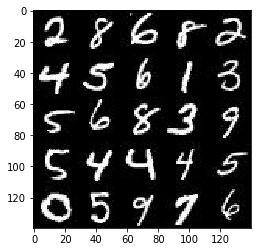

In [33]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

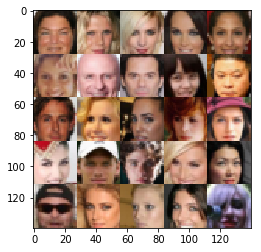

In [34]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [36]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [87]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.1
        
        # input layer 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        #print(relu1.get_shape())
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        #print(relu2.get_shape())
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        #print(relu3.get_shape())
        
        # Flatten
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [88]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.1
        # First Fully connected nets
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape to conv stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        #print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        #print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128
        #print(x3.get_shape())
        
        # Output
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28xout_channel_dim
        #print(logits.get_shape())
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [89]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [90]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [91]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [92]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]
    
    show_n_images = 25
    
    input_real, input_z, learning_rate_holder = model_inputs(image_width, image_height, output_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, output_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_holder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learning_rate_holder: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learning_rate_holder: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, output_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4858... Generator Loss: 2.4701
Epoch 1/2... Discriminator Loss: 0.4307... Generator Loss: 2.7045
Epoch 1/2... Discriminator Loss: 0.3810... Generator Loss: 3.3547
Epoch 1/2... Discriminator Loss: 0.4353... Generator Loss: 3.3651
Epoch 1/2... Discriminator Loss: 0.4015... Generator Loss: 3.4473
Epoch 1/2... Discriminator Loss: 1.8983... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 2.0092... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.8700... Generator Loss: 0.4889
Epoch 1/2... Discriminator Loss: 1.7018... Generator Loss: 0.4645
Epoch 1/2... Discriminator Loss: 1.7345... Generator Loss: 0.4551


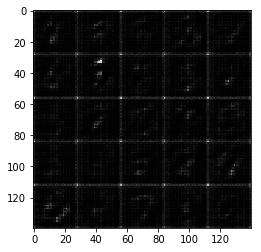

Epoch 1/2... Discriminator Loss: 1.5863... Generator Loss: 0.6734
Epoch 1/2... Discriminator Loss: 1.7409... Generator Loss: 0.3678
Epoch 1/2... Discriminator Loss: 1.7037... Generator Loss: 0.4755
Epoch 1/2... Discriminator Loss: 1.5680... Generator Loss: 0.5913
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.6307
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.4982... Generator Loss: 0.4723
Epoch 1/2... Discriminator Loss: 1.3613... Generator Loss: 0.8109
Epoch 1/2... Discriminator Loss: 1.6102... Generator Loss: 0.3958


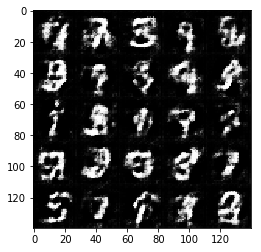

Epoch 1/2... Discriminator Loss: 1.6118... Generator Loss: 0.4053
Epoch 1/2... Discriminator Loss: 1.6971... Generator Loss: 0.3806
Epoch 1/2... Discriminator Loss: 1.7280... Generator Loss: 0.3464
Epoch 1/2... Discriminator Loss: 1.4037... Generator Loss: 0.6839
Epoch 1/2... Discriminator Loss: 1.3415... Generator Loss: 1.1145
Epoch 1/2... Discriminator Loss: 1.5809... Generator Loss: 0.5514
Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.3796
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.8154
Epoch 1/2... Discriminator Loss: 1.4177... Generator Loss: 0.6258
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.7843


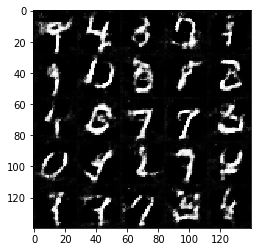

Epoch 1/2... Discriminator Loss: 1.7118... Generator Loss: 0.3587
Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.4852
Epoch 1/2... Discriminator Loss: 1.5184... Generator Loss: 0.5136
Epoch 1/2... Discriminator Loss: 1.6879... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 1.5657... Generator Loss: 0.5490
Epoch 1/2... Discriminator Loss: 1.6833... Generator Loss: 0.3890
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.6489... Generator Loss: 0.4069
Epoch 1/2... Discriminator Loss: 1.5101... Generator Loss: 0.5165
Epoch 1/2... Discriminator Loss: 1.4470... Generator Loss: 0.5990


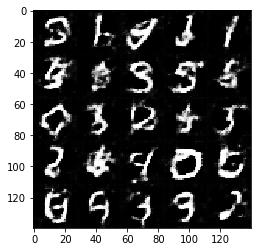

Epoch 1/2... Discriminator Loss: 1.4918... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.6091
Epoch 1/2... Discriminator Loss: 1.5750... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.4300... Generator Loss: 0.6878
Epoch 1/2... Discriminator Loss: 1.4073... Generator Loss: 0.7058
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.5548... Generator Loss: 0.4388
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.9333


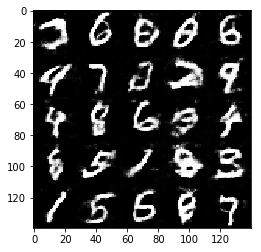

Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.7232
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.6505
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.6992
Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.7092
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.6745
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.5288
Epoch 1/2... Discriminator Loss: 1.5939... Generator Loss: 0.4502
Epoch 1/2... Discriminator Loss: 1.5778... Generator Loss: 0.4203
Epoch 1/2... Discriminator Loss: 1.4364... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.4318


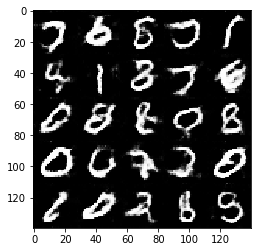

Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.5744... Generator Loss: 0.4689
Epoch 1/2... Discriminator Loss: 1.2955... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.5175... Generator Loss: 0.4980
Epoch 1/2... Discriminator Loss: 1.3014... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.5747... Generator Loss: 0.4708
Epoch 1/2... Discriminator Loss: 1.3989... Generator Loss: 1.2802
Epoch 1/2... Discriminator Loss: 1.5165... Generator Loss: 0.5468
Epoch 1/2... Discriminator Loss: 1.5104... Generator Loss: 0.8940


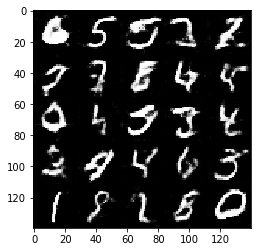

Epoch 1/2... Discriminator Loss: 1.3715... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.5993... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 0.4598
Epoch 1/2... Discriminator Loss: 1.3971... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.5467... Generator Loss: 0.4526
Epoch 1/2... Discriminator Loss: 1.5178... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 1.4936... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 1.4450... Generator Loss: 0.8576


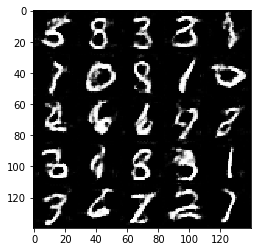

Epoch 1/2... Discriminator Loss: 1.6024... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.7983
Epoch 1/2... Discriminator Loss: 1.5522... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.4776... Generator Loss: 0.7148
Epoch 1/2... Discriminator Loss: 1.8248... Generator Loss: 0.2910
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.9499
Epoch 1/2... Discriminator Loss: 1.8660... Generator Loss: 0.2962
Epoch 1/2... Discriminator Loss: 1.7753... Generator Loss: 0.3406
Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.6850... Generator Loss: 0.3451


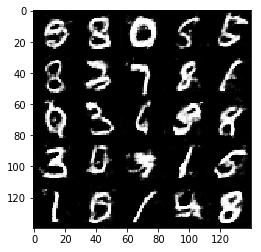

Epoch 1/2... Discriminator Loss: 1.4834... Generator Loss: 0.4857
Epoch 1/2... Discriminator Loss: 1.6652... Generator Loss: 0.3552
Epoch 1/2... Discriminator Loss: 1.4636... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.5485... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 1.6066... Generator Loss: 0.4555
Epoch 2/2... Discriminator Loss: 1.4683... Generator Loss: 0.5547
Epoch 2/2... Discriminator Loss: 1.5296... Generator Loss: 0.5358
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.6198
Epoch 2/2... Discriminator Loss: 1.5795... Generator Loss: 0.4391
Epoch 2/2... Discriminator Loss: 1.4534... Generator Loss: 1.0156


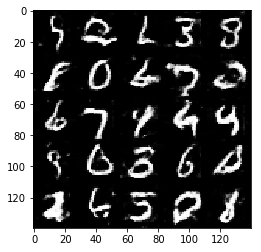

Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 1.5191... Generator Loss: 0.4690
Epoch 2/2... Discriminator Loss: 1.6844... Generator Loss: 0.3530
Epoch 2/2... Discriminator Loss: 1.5490... Generator Loss: 0.4652
Epoch 2/2... Discriminator Loss: 1.4539... Generator Loss: 0.5246
Epoch 2/2... Discriminator Loss: 1.8785... Generator Loss: 0.2896
Epoch 2/2... Discriminator Loss: 1.4513... Generator Loss: 0.5919
Epoch 2/2... Discriminator Loss: 1.4750... Generator Loss: 0.6778
Epoch 2/2... Discriminator Loss: 1.7586... Generator Loss: 0.3211
Epoch 2/2... Discriminator Loss: 1.5967... Generator Loss: 0.4275


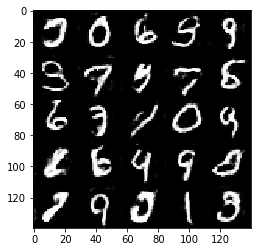

Epoch 2/2... Discriminator Loss: 1.4120... Generator Loss: 0.6707
Epoch 2/2... Discriminator Loss: 1.4496... Generator Loss: 1.1492
Epoch 2/2... Discriminator Loss: 1.7066... Generator Loss: 0.3825
Epoch 2/2... Discriminator Loss: 1.5258... Generator Loss: 0.5118
Epoch 2/2... Discriminator Loss: 1.4945... Generator Loss: 0.4497
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.5620
Epoch 2/2... Discriminator Loss: 1.6915... Generator Loss: 0.3408
Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.4619
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.6889
Epoch 2/2... Discriminator Loss: 1.5588... Generator Loss: 0.4350


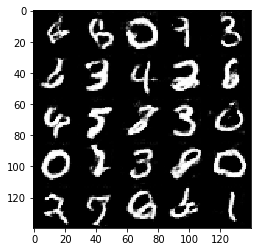

Epoch 2/2... Discriminator Loss: 1.4561... Generator Loss: 0.5174
Epoch 2/2... Discriminator Loss: 1.7873... Generator Loss: 0.3037
Epoch 2/2... Discriminator Loss: 1.5375... Generator Loss: 0.6025
Epoch 2/2... Discriminator Loss: 1.4099... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 1.4139... Generator Loss: 0.8789
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.5673... Generator Loss: 0.4534
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 1.7540... Generator Loss: 0.4397
Epoch 2/2... Discriminator Loss: 1.5339... Generator Loss: 0.4483


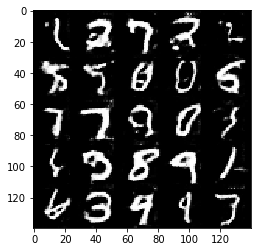

Epoch 2/2... Discriminator Loss: 1.4632... Generator Loss: 0.5113
Epoch 2/2... Discriminator Loss: 1.7295... Generator Loss: 0.3415
Epoch 2/2... Discriminator Loss: 1.3705... Generator Loss: 0.5701
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.6285
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 1.6335... Generator Loss: 0.3614
Epoch 2/2... Discriminator Loss: 1.4506... Generator Loss: 0.7741
Epoch 2/2... Discriminator Loss: 2.5358... Generator Loss: 0.1461
Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.6796


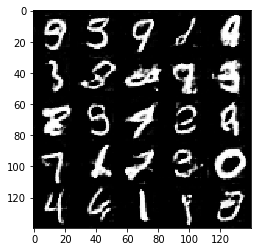

Epoch 2/2... Discriminator Loss: 1.7055... Generator Loss: 0.3349
Epoch 2/2... Discriminator Loss: 1.6165... Generator Loss: 0.4430
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.6157
Epoch 2/2... Discriminator Loss: 1.5021... Generator Loss: 0.5003
Epoch 2/2... Discriminator Loss: 1.9151... Generator Loss: 0.2904
Epoch 2/2... Discriminator Loss: 1.5346... Generator Loss: 0.4647
Epoch 2/2... Discriminator Loss: 1.6398... Generator Loss: 0.3664
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.8853
Epoch 2/2... Discriminator Loss: 1.5123... Generator Loss: 0.5027


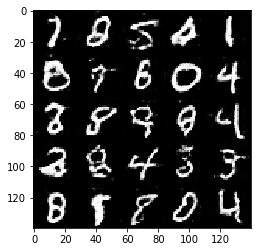

Epoch 2/2... Discriminator Loss: 1.4589... Generator Loss: 0.6922
Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 0.5591
Epoch 2/2... Discriminator Loss: 1.6579... Generator Loss: 0.3586
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 0.9594
Epoch 2/2... Discriminator Loss: 1.4938... Generator Loss: 0.4416
Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.9239
Epoch 2/2... Discriminator Loss: 1.7086... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: 1.4720... Generator Loss: 0.5356
Epoch 2/2... Discriminator Loss: 1.3971... Generator Loss: 0.5873
Epoch 2/2... Discriminator Loss: 1.6021... Generator Loss: 0.4050


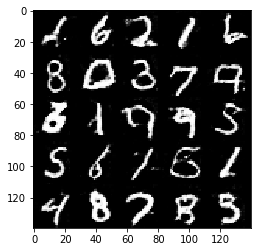

Epoch 2/2... Discriminator Loss: 1.6762... Generator Loss: 0.3937
Epoch 2/2... Discriminator Loss: 1.4925... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 1.5946... Generator Loss: 0.4191
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.5293
Epoch 2/2... Discriminator Loss: 2.2588... Generator Loss: 0.1931
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.5162
Epoch 2/2... Discriminator Loss: 1.9567... Generator Loss: 0.2704
Epoch 2/2... Discriminator Loss: 1.7915... Generator Loss: 0.3280
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.9661


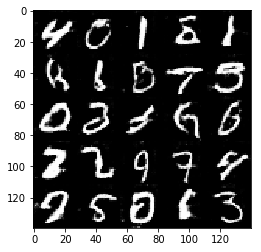

Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 0.7262
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.7021
Epoch 2/2... Discriminator Loss: 1.5062... Generator Loss: 0.4526
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 2.3350... Generator Loss: 0.1713
Epoch 2/2... Discriminator Loss: 1.3518... Generator Loss: 0.6057
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.7172
Epoch 2/2... Discriminator Loss: 1.5306... Generator Loss: 0.8829


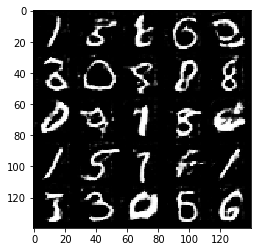

Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.6523
Epoch 2/2... Discriminator Loss: 1.3050... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 1.4867... Generator Loss: 0.4757
Epoch 2/2... Discriminator Loss: 1.4948... Generator Loss: 0.5136
Epoch 2/2... Discriminator Loss: 1.7796... Generator Loss: 0.3379
Epoch 2/2... Discriminator Loss: 1.5079... Generator Loss: 0.4359
Epoch 2/2... Discriminator Loss: 1.4830... Generator Loss: 0.4896


In [93]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.5531
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 2.0959... Generator Loss: 0.2529
Epoch 1/1... Discriminator Loss: 2.1885... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 2.2612... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 2.5008... Generator Loss: 0.2659
Epoch 1/1... Discriminator Loss: 2.3299... Generator Loss: 0.3151
Epoch 1/1... Discriminator Loss: 2.0034... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.7966... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.7871... Generator Loss: 0.5115


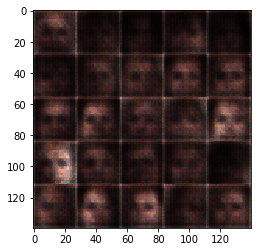

Epoch 1/1... Discriminator Loss: 1.6960... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.8089... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.6991... Generator Loss: 0.5584
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.5473... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.7117... Generator Loss: 0.4301


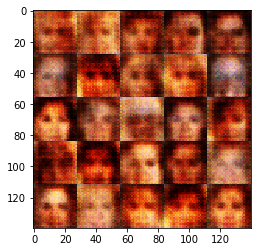

Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.6055... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.5713... Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.5865... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.6948


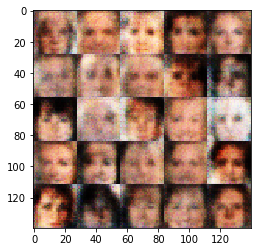

Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.5595... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.5884... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.7366


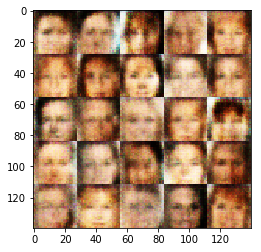

Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.5707... Generator Loss: 0.6255
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7902


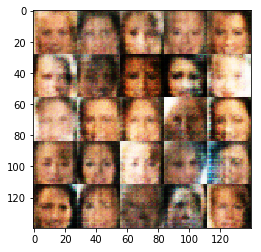

Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.5265... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7762


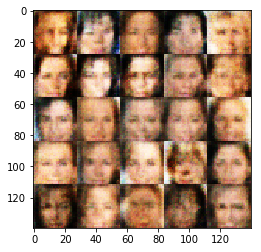

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4935... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.7306


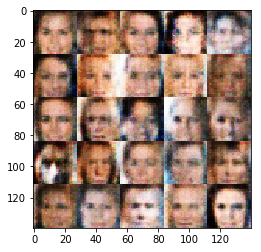

Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.5404... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7573


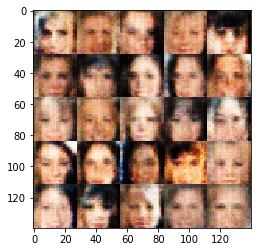

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4997... Generator Loss: 0.6964


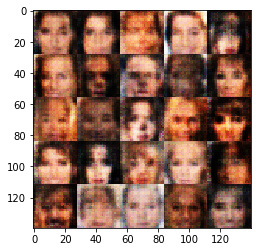

Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7518
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.5305... Generator Loss: 0.6777


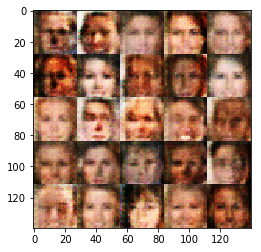

Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7445


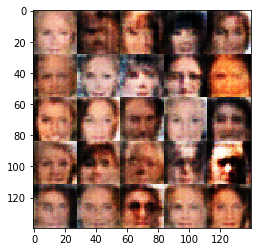

Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7413


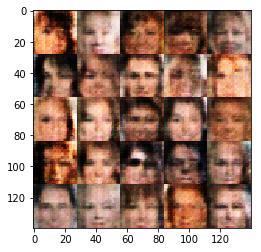

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7321


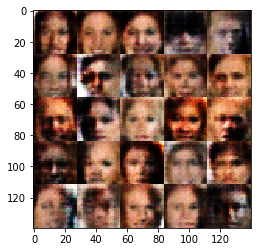

Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6164


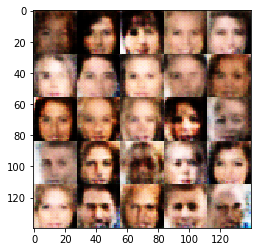

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7458


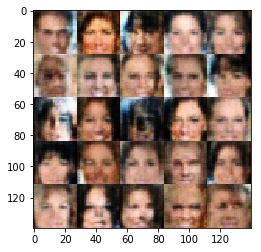

Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7531


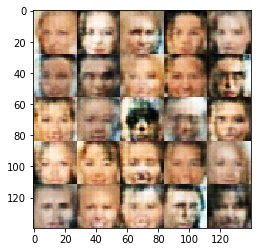

Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8067
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7405


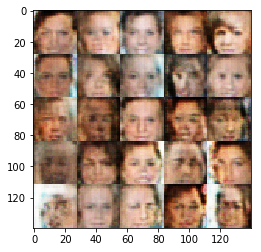

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 0.6864


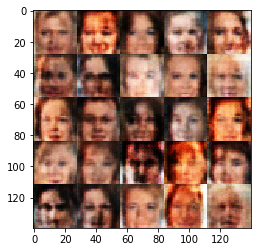

Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7692


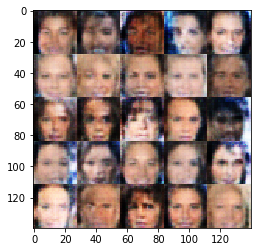

Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7684


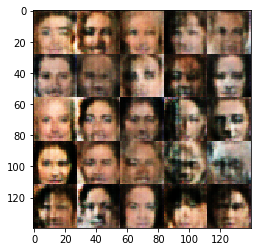

Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.7004


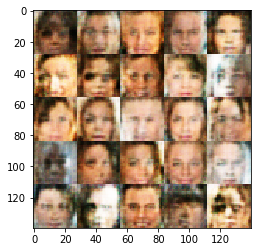

Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7581


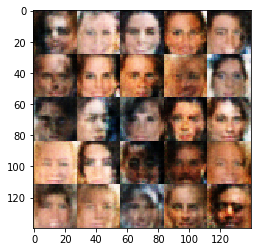

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7927


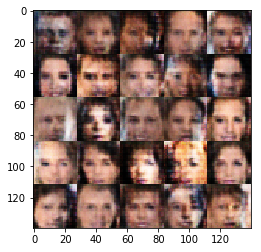

Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7653


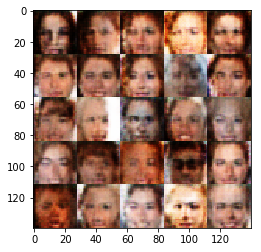

Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8108


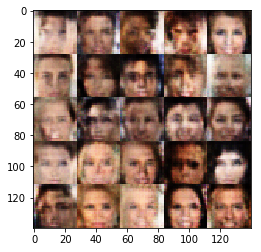

Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7578


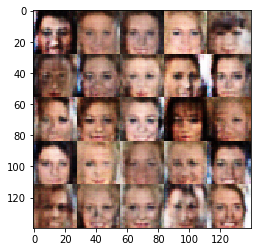

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7964


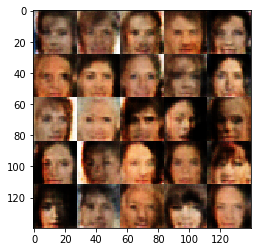

Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7710


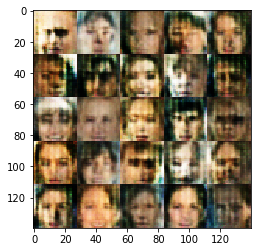

Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7556


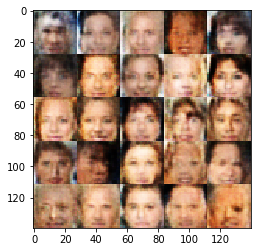

Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7773


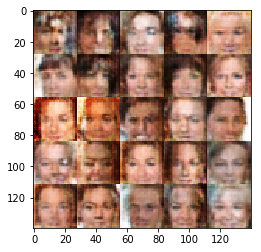

Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8261


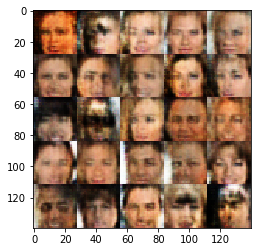

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7523


In [94]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.